In [1]:
import cv2 as cv
import scipy
import numpy
import math
import os
import random
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from skimage.util import random_noise
from skimage.morphology import disk
from matplotlib import pyplot as plt
from deap import base, creator, tools, algorithms

In [2]:
import importlib
from util import performance_functions
from util.weak_texture_patches import noise_level, weak_texture_mask
from util.denoising_functions import *
importlib.reload(performance_functions)

<module 'util.performance_functions' from '/home/sam/Documents/Notes/UCC/FYP/util/performance_functions.py'>

## Resources

- Source code: https://uk.mathworks.com/matlabcentral/fileexchange/36921-noise-level-estimation-from-a-single-image
- MATLAB to python: https://cheatsheets.quantecon.org/, http://mathesaurus.sourceforge.net/matlab-numpy.html



In [3]:
test_image = cv.imread('images/42078.jpg')
test_image = test_image[:,:,::-1]


[0.13994551450950854, 0.14116239518011633, 0.16288527404448924] [6.885422392394682, 7.0200745027640465, 9.112892926465541] [14746, 22057, 20132]


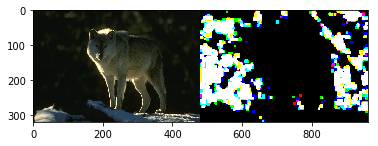

[0.009492330110826112, 0.009505054123536335, 0.009544196978481297] [0.004890233162200249, 0.004884957166993509, 0.005019772022667526] [69049, 72030, 77601]


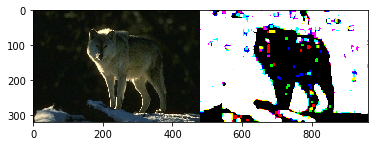

In [4]:
nlevel, th, num = noise_level(test_image)
print(nlevel, th, num)
msk1 = weak_texture_mask(test_image, th )
disp1 = numpy.hstack((test_image,msk1.astype(numpy.uint8) * 255))
plt.imshow(disp1)
plt.show()

noisy_image = random_noise(test_image, mode="gaussian", var=0.0001)
nlevel, th, num = noise_level(noisy_image, conf=0.97)
print(nlevel, th, num)
msk2 = weak_texture_mask(noisy_image, th)
disp2 = numpy.hstack((noisy_image* 255,msk2 * 255)).astype(numpy.uint8)
plt.imshow(disp2)
plt.show()

/home/sam/Documents/Notes/UCC/FYP/env/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Fitness when applying no denoising algorithm:  50530275.289175436
-------------
Fitness after applying denoising algorithm:  53730132


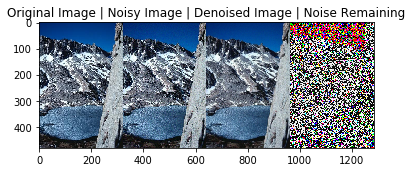


Testing fitness funtion with optional display parameter:


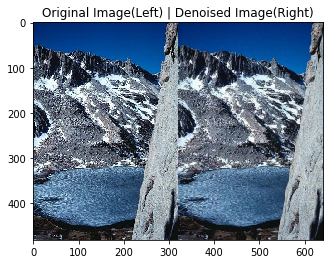

Result:  13.350636436796961


In [5]:
def evaluate_fitness(denoised_image, original_image, display_images=False):
    
    if display_images:
        
        merged_images = numpy.hstack((original_image,denoised_image))
        plt.title("Original Image(Left) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
    return performance_functions.root_mean_squared_error(denoised_image, original_image)

fitness_test_image = cv.imread('images/167083.jpg')

noisy_test_images = random_noise(fitness_test_image, mode="gaussian", var=0.0002)

denoised_test_image = filters.gaussian(noisy_test_images,sigma=0.61)
denoised_test_image *= 255
denoised_test_image = denoised_test_image.astype(numpy.uint8)

baseline = fitness_test_image - noisy_test_images

test_fitness = fitness_test_image - denoised_test_image

print("Fitness when applying no denoising algorithm: ",numpy.absolute(baseline).sum())
print("-------------")
print("Fitness after applying denoising algorithm: ", numpy.absolute(test_fitness).sum())

all_images_merged = numpy.hstack((fitness_test_image,noisy_test_images*255,denoised_test_image,test_fitness)).astype(numpy.uint8)
rgb_all_images = cv.cvtColor(all_images_merged, cv.COLOR_BGR2RGB)
plt.imshow(rgb_all_images)
plt.title("Original Image | Noisy Image | Denoised Image | Noise Remaining")
plt.show()

denoised_test_image =  cv.cvtColor(denoised_test_image, cv.COLOR_BGR2RGB)
fitness_test_image =  cv.cvtColor(fitness_test_image, cv.COLOR_BGR2RGB)
print("\nTesting fitness funtion with optional display parameter:")
print("Result: ", evaluate_fitness(denoised_test_image, fitness_test_image, display_images=True))

In [6]:
import sys
class ImageDataset:
    
    def __init__(self, size, sigma=0.0002):
        self.dir_location = "images/"
        self.base_images = []
        self.noisy_images = []
        self.weak_texture_masks = []
        self.noise_levels = []
        self.sigma = sigma
        self.load_files(size)
        
        
    def load_files(self, size):
        self.base_images = []
        for image_name in os.listdir(self.dir_location):
            if len(self.base_images) >= size:
                break
            new_image = cv.imread(self.dir_location+image_name);
            new_image = new_image[:,:,::-1]
            self.base_images += [new_image]
            noisy_image = random_noise(new_image, mode="gaussian", var=self.sigma)
            
            self.noisy_images += [noisy_image]
            try:
                nlevel, th, num = noise_level(noisy_image, conf=0.97)
                self.noise_levels += [nlevel]
                new_image_mask = weak_texture_mask(noisy_image,th)
                self.weak_texture_masks += [new_image_mask]
            except Exception as e:
                print(e)
                plt.imshow(new_image)
                plt.show()
            
            
            
        

In [7]:
images = ImageDataset(2,0.0005)

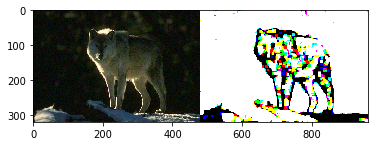

In [8]:
img_and_mask = numpy.hstack((images.noisy_images[1]*255,images.weak_texture_masks[1]*255)).astype(numpy.uint8)
plt.imshow(img_and_mask)
plt.show()

## Sensors

| Sensor ID | Sensor Data |
| --- | --- |
| 0 | weak texture mask |
| 1 | non weak texture mask |

## Actions

| Action ID | Action |
| --- | --- |
| 0 | gaussian_filter_coins sigma 1 | 
| 1 | gaussian_filter_coins sigma 2 |
| 2 | median_filter one(3, 3) |
| 3 | tv_chambolle weight 0.1 |

In [15]:
import random
from deap import algorithms, base, creator, tools

NUM_FILTERS = 8
SIZE_OF_INDIVIDUAL = math.ceil(math.log2(NUM_FILTERS**2))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

evaluation = lambda i : evaluate(i, images)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=SIZE_OF_INDIVIDUAL)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluation)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=40)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)

gen	nevals
0  	40    
1  	23    
2  	29    
3  	29    
4  	24    
5  	24    
6  	29    
7  	20    
8  	24    
9  	27    
10 	25    


([[1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0],
  [1, 0, 1, 1, 1, 0]],
 [{'gen': 0, 'nevals': 40},
  {'gen': 1, 'nevals': 23},
  {'gen': 2, 'nevals': 29},
  {'gen': 3, 'nevals': 29},
  {'gen

[1, 0, 1, 1, 1, 0]
PSNR: 34.574284
 IQI: 0.999709
 SSIM: 0.967490



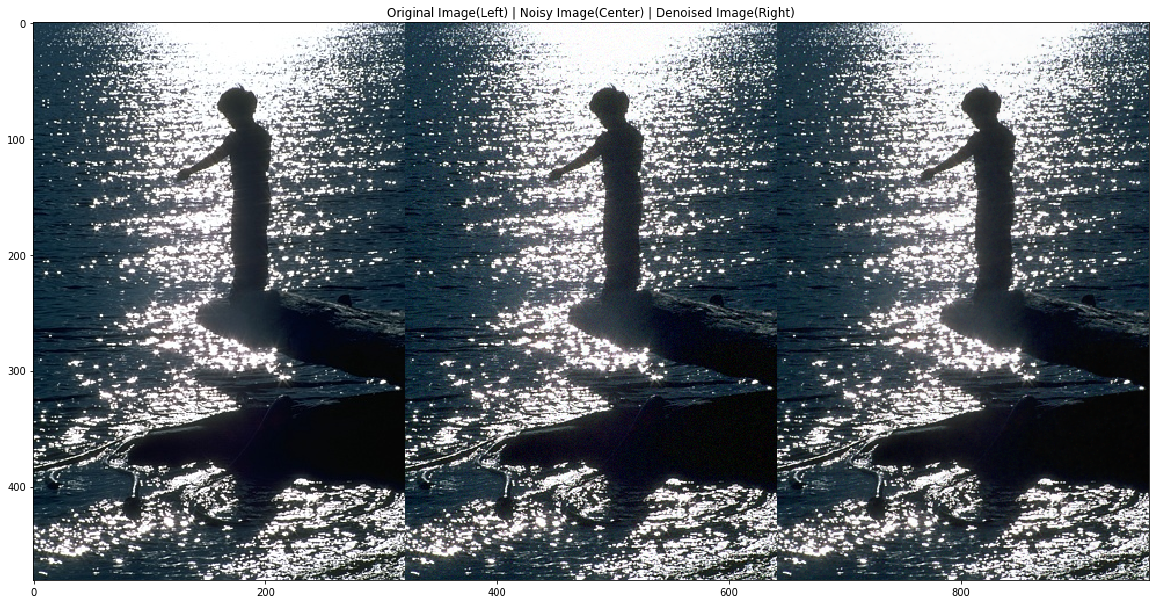

(8.114770224314489,)


In [16]:
print(tools.selBest(pop, k=1)[0])
print(evaluate(tools.selBest(pop, k=1)[0], images, True))

In [17]:
def compare_results(individual):
    test_image_rmse = evaluate(individual, images, True)
    new_image_rmse = evaluate(individual, images, True, 1)
    print("Test Image RMSE: %f \nUnseen Image RMSE: %f"%(test_image_rmse[0], new_image_rmse[0]))
    print("Test Image Estimated Noise:", images.noise_levels[0])
    print("Unseen Image Estimated Noise:", images.noise_levels[1])

PSNR: 34.574284
 IQI: 0.999709
 SSIM: 0.967490



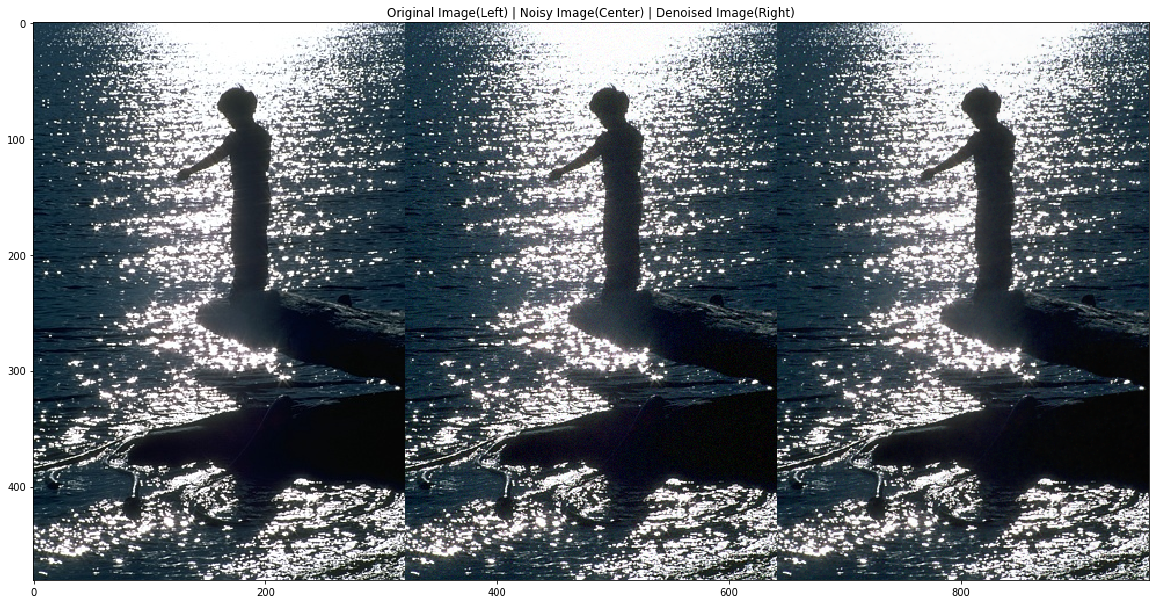

PSNR: 37.844499
 IQI: 0.998822
 SSIM: 0.940204



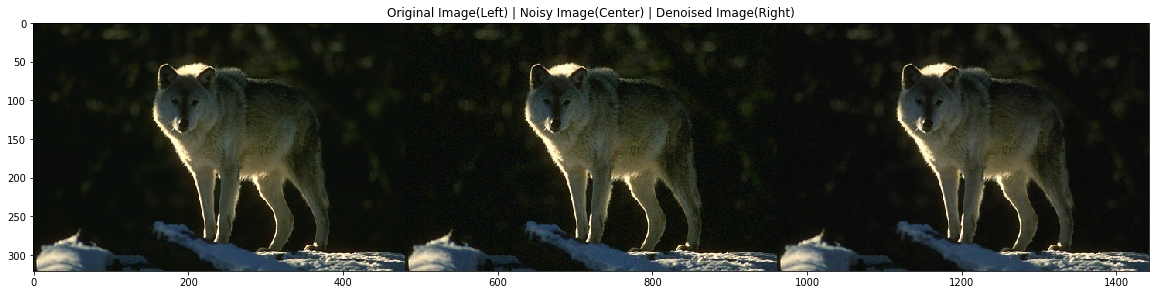

Test Image RMSE: 8.114770 
Unseen Image RMSE: 5.635823
Test Image Estimated Noise: [0.018587110763087816, 0.019107630114350124, 0.019910895603859995]
Unseen Image Estimated Noise: [0.02063189292275646, 0.021147553411521684, 0.020347375707905773]


In [18]:
compare_results(tools.selBest(pop, k=1)[0])